### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *

### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


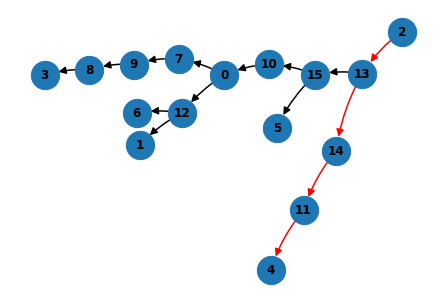

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

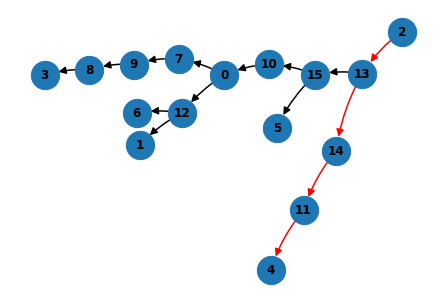

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
for tokens, masks in test_loader:
    for i in range(tokens.shape[0]):
        t = tokens[i]
        m = masks[i]
        print("Prompt:", dataset.untokenize(t[~m]))
        print("Completion:", dataset.untokenize(t[m]), end="\n\n")
    break

Prompt: 14>4,14>8,2>3,11>6,15>12,15>0,15>11,2>1,13>7,8>15,13>10,11>13,8>9,12>5,9>2|5:14
Completion: >8>15>12>5

Prompt: 2>4,15>3,8>10,7>15,12>2,2>5,7>6,5>1,5>9,15>14,10>13,8>0,12>8,8>7,10>11|1:12
Completion: >2>5>1

Prompt: 3>13,3>4,15>0,15>8,15>5,4>10,1>9,11>6,11>14,4>1,10>12,12>11,7>15,14>2,10>7|5:3
Completion: >4>10>7>15>5

Prompt: 7>13,7>12,13>2,7>5,5>4,0>6,14>0,0>8,13>11,11>15,1>14,8>7,2>9,5>3,2>10|4:1
Completion: >14>0>8>7>5>4

Prompt: 8>15,15>3,12>7,14>2,2>10,8>14,13>5,6>12,15>11,10>9,14>4,8>1,5>8,13>0,5>6|1:13
Completion: >5>8>1

Prompt: 10>5,14>3,2>9,4>14,5>6,9>0,11>2,15>8,10>13,11>7,15>4,11>10,13>12,2>15,8>1|7:11
Completion: >7

Prompt: 7>14,5>1,13>0,9>10,15>6,2>11,9>8,4>3,15>12,14>5,2>9,15>2,0>15,0>7,7>4|1:13
Completion: >0>7>14>5>1

Prompt: 13>7,6>15,5>3,10>8,12>14,14>4,11>5,14>0,4>11,7>1,0>13,2>9,7>6,5>2,8>12|15:10
Completion: >8>12>14>0>13>7>6>15

Prompt: 13>6,14>4,7>9,11>2,12>10,3>7,3>8,15>1,5>15,6>3,10>13,9>0,14>12,9>11,7>5|4:14
Completion: >4

Prompt: 15>11,13>14,15>12

In [5]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [6]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

12>2,11>3,6>12,15>8,14>15,3>10,7>1,4>0,9>5,7>9,4>7,6>11,14>13,14>4,0>6|8:14>15>8


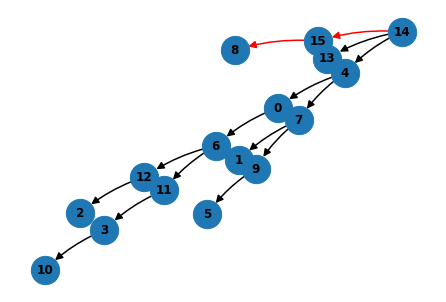

In [7]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="random")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)
print(pred)

In [8]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%


### Experiment: Looking at Embeddings

In [ ]:
model.W_E

### Experiment: Attention Visualization + Masking

### Experiment: Activation Patching